# Model Selection - Regression

Testing out different regression models and selecting what seems to perform the best. (I honestly have no idea what I'm doing.)

One thing I didn't realize earlier is that I don't have a lot of data points.
I hope I can train a model to do something at all...

## Setup

In [148]:
import csv
import json
import os
import time
from datetime import datetime,timedelta

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame

# suppress future warnings for xgboost and unsupported kanji unicode in plots
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score,accuracy_score
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.tree import DecisionTreeRegressor

In [149]:
SEED = 1337
data_dir = os.path.abspath('data')

# today = datetime.today().strftime('%Y%m%d')
today = datetime.strptime('2022-09-27', '%Y-%m-%d').strftime('%Y%m%d')

In [150]:
# util to print general regression model performance
def print_model_error(y_test, y_pred):
    print('MAE  =', mean_absolute_error(y_test, y_pred))
    print('MSE  =', mean_squared_error(y_test, y_pred))
    print('RMSE =', np.sqrt(mean_squared_error(y_test, y_pred)))
    print('R^2  =', r2_score(y_test, y_pred))

## Encoding

In [151]:
# binary encode a column of categorical data
def binary_encode(df: DataFrame, col: str) -> DataFrame:
    try:
        df[col] = df[col].apply(json.loads) # deserialize JSON array
    except ValueError: pass

    encoded = df.explode(col) # expand categorical data into rows
    encoded = pd.concat([df, pd.get_dummies(encoded[col], prefix=col, prefix_sep='_')], axis=1) # convert to indicators
    encoded = encoded.groupby('id').max().reset_index() # squash rows
    return encoded.drop([col], axis=1) # drop encoded column

In [152]:
# Binary encodes tags,genres,studios. Binary encoding eliminates possible
# data leaks that occur with one-hot encoding since it retains one row per entity.

encoded_df = pd.read_csv(os.path.join(data_dir, f'user-{today}-enriched.csv'))
cols = ['format', 'season', 'source', 'genres', 'studios', 'tags']

# binary encode each categorical column
for col in cols:
    encoded_df = binary_encode(encoded_df, col)
encoded_df.drop(['id'], axis=1, inplace=True)

encoded_df.to_csv(os.path.join(data_dir, f'user-{today}-reg-encoded.csv'), index=False)
print(encoded_df.shape)

(556, 426)


## Split and Scale Data

In [153]:
# split data into train,test,validation sets

# scaler = StandardScaler()
scaler = MinMaxScaler()

X = encoded_df[encoded_df.columns.drop(['score'])]
X = DataFrame(scaler.fit_transform(X), columns=X.columns)
y = encoded_df['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=SEED, shuffle=True)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.75, random_state=SEED, shuffle=True)

print('X_train =', X_train.shape, '; y_train =', y_train.shape)
print('X_valid =', X_valid.shape, '; y_valid =', y_valid.shape)
print('X_test =', X_test.shape, '; y_test =', y_test.shape)

# save to CSV for quick glancing data
X_train.to_csv(os.path.join(data_dir, f'user-{today}-reg-train.csv'), index=False)
X_valid.to_csv(os.path.join(data_dir, f'user-{today}-reg-valid.csv'), index=False)
X_test.to_csv(os.path.join(data_dir, f'user-{today}-reg-test.csv'), index=False)

X_train = (333, 425) ; y_train = (333,)
X_valid = (111, 425) ; y_valid = (111,)
X_test = (112, 425) ; y_test = (112,)


## Regression Tree

Actual: [8, 5, 6, 6, 7]
Predictions: [6.0, 9.0, 6.0, 5.0, 8.0]
MAE  = 1.25
MSE  = 3.0892857142857144
RMSE = 1.7576363999091833
R^2  = -0.6323504633529906


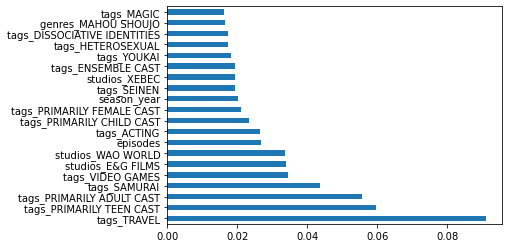

CPU times: total: 156 ms
Wall time: 166 ms


In [154]:
%%time

# run with base hyper parameters

model = DecisionTreeRegressor(random_state=SEED)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('Actual:', y_test.head().tolist())
print('Predictions:', y_pred.tolist()[0:5])
print_model_error(y_test, y_pred)

feat_importances = pd.Series(model.feature_importances_, index=X_test.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

In [155]:
%%time

# Find best hyperparameters
#   https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html
#   https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

hyper_best = {'criterion': 'mse', 'max_depth': 2, 'max_leaf_nodes': 2}

if not hyper_best:
    param_grid = {
        'criterion': ['mse', 'mae'],
        # 'min_samples_split': [10, 20, 40],
        # 'min_samples_leaf': [20, 40, 100],
        'max_depth': [2, 3, 4, 8, 16, 32],
        'max_leaf_nodes': [2, 5, 10, 15, 18, 20, 25, 50],
    }
    hyper_search = GridSearchCV(DecisionTreeRegressor(random_state=SEED), param_grid, cv=3, verbose=1).fit(X_train, y_train)
    hyper_best = hyper_search.best_params_

print('Best hyperparameters =', hyper_best)

Best hyperparameters = {'criterion': 'mse', 'max_depth': 2, 'max_leaf_nodes': 2}
CPU times: total: 0 ns
Wall time: 503 µs


Actual: [8, 5, 6, 6, 7, 8, 6, 8, 6, 10]
Predictions: [6.782608695652174, 6.782608695652174, 6.782608695652174, 6.782608695652174, 6.782608695652174, 6.782608695652174, 6.782608695652174, 6.782608695652174, 6.782608695652174, 6.782608695652174]
MAE  = 1.0308960540738035
MSE  = 1.7714742477108711
RMSE = 1.3309674104616052
R^2  = 0.06396912538815647


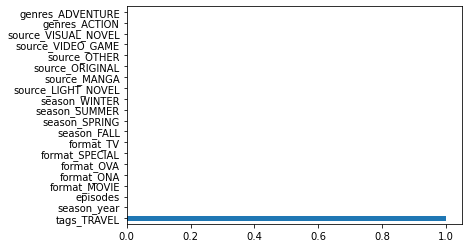

CPU times: total: 156 ms
Wall time: 168 ms


In [156]:
%%time

# Try retraining model with new hyperparameters

model = DecisionTreeRegressor(**hyper_best)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('Actual:', y_test.tolist()[0:10])
print('Predictions:', y_pred.tolist()[0:10])
print_model_error(y_test, y_pred)

feat_importances = pd.Series(model.feature_importances_, index=X_test.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

## Random Forest Regression

Actual: [8, 5, 6, 6, 7, 8, 6, 8, 6, 10]
Predictions: [6.69, 6.85, 6.23, 6.02, 6.4, 6.75, 5.68, 6.81, 6.8, 7.09]
MAE  = 0.8937499999999999
MSE  = 1.2568035714285715
RMSE = 1.1210725094428868
R^2  = 0.33591642796967147


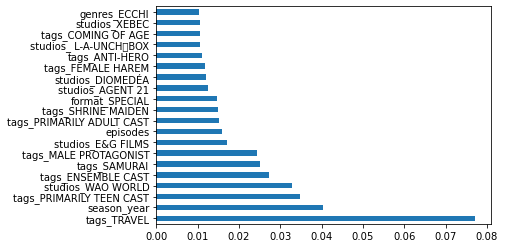

CPU times: total: 703 ms
Wall time: 720 ms


In [157]:
%%time

# run with base hyper parameters

model = RandomForestRegressor(random_state=SEED)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('Actual:', y_test.tolist()[0:10])
print('Predictions:', y_pred.tolist()[0:10])
print_model_error(y_test, y_pred)

feat_importances = pd.Series(model.feature_importances_, index=X_test.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

In [158]:
%%time

# Find best hyperparameters
#   https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
#   https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

hyper_best = {'criterion': 'poisson', 'max_features': 'log2', 'max_leaf_nodes': 128, 'n_estimators': 1000}

if not hyper_best:
    param_grid = {
        'criterion': ['squared_error', 'absolute_error', 'poisson'],
        # 'max_depth': [2, 4, 8, 16, 32, 64, 128],
        'n_estimators': [10, 25, 50, 100, 250, 500, 1000],
        # 'min_samples_split': [2, 6, 10],
        # 'min_samples_leaf': [1, 3, 4],
        'max_leaf_nodes': [2, 4, 8, 16, 32, 64, 128],
        'max_features': ['auto', 'sqrt', 'log2'],
    }
    hyper_search = GridSearchCV(RandomForestRegressor(random_state=SEED), param_grid, cv=3, verbose=1).fit(X_train, y_train)
    hyper_best = hyper_search.best_params_

print('Best hyperparameters =', hyper_best)

Best hyperparameters = {'criterion': 'poisson', 'max_features': 'log2', 'max_leaf_nodes': 128, 'n_estimators': 1000}
CPU times: total: 0 ns
Wall time: 497 µs


Actual: [8, 5, 6, 6, 7, 8, 6, 8, 6, 10]
Predictions: [7.7967534569285695, 6.793044107740364, 6.920948246623983, 5.840445329937522, 6.709233130509007, 6.978124631352427, 6.387874003929214, 7.36625821182125, 6.896921122225468, 7.549139871673573]
MAE  = 0.8256821320066318
MSE  = 1.1050695341966625
RMSE = 1.051222875605674
R^2  = 0.4160913126805841


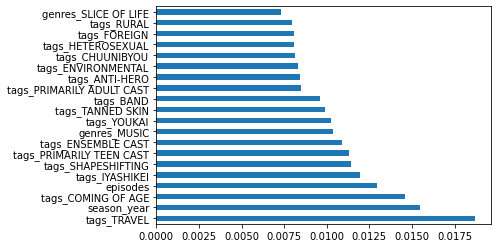

CPU times: total: 1.45 s
Wall time: 1.48 s


In [159]:
%%time

# Try retraining model with new hyperparameters

model = RandomForestRegressor(**hyper_best)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('Actual:', y_test.tolist()[0:10])
print('Predictions:', y_pred.tolist()[0:10])
print_model_error(y_test, y_pred)

feat_importances = pd.Series(model.feature_importances_, index=X_test.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

## XGBoost

Actual: [8, 5, 6, 6, 7, 8, 6, 8, 6, 10]
Predictions: [6.867570877075195, 6.897963047027588, 6.377411842346191, 6.061590671539307, 5.378866672515869, 7.559496879577637, 4.393950939178467, 7.491154193878174, 6.283590316772461, 7.044008731842041]
MAE  = 0.9206143234457288
MSE  = 1.360060456268077
RMSE = 1.166216299092101
R^2  = 0.2813564295102461


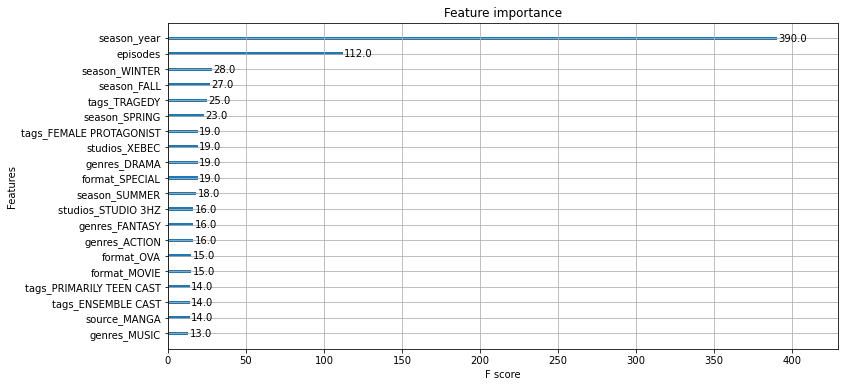

CPU times: total: 2.64 s
Wall time: 787 ms


In [160]:
%%time

# run with base hyper parameters

model = xgb.XGBRegressor(random_state=SEED)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('Actual:', y_test.tolist()[0:10])
print('Predictions:', y_pred.tolist()[0:10])
print_model_error(y_test, y_pred)

fig, ax = plt.subplots(figsize=(12,6))
xgb.plot_importance(model, max_num_features=20, ax=ax)
plt.show()

In [161]:
%%time

# Find best hyperparameters
#   https://xgboost.readthedocs.io/en/stable/python/python_api.html#module-xgboost.sklearn
#   https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

hyper_best = {'learning_rate': 0.025, 'max_depth': 4, 'n_estimators': 500}

if not hyper_best:
    param_grid = {
        'max_depth': [3, 4, 5, 6],
        # 'min_child_weight': [2, 4, 8]
        'learning_rate': [0.01, 0.025],
        'n_estimators': [10, 25, 50, 100, 250, 500, 1000],
    }
    hyper_search = GridSearchCV(xgb.XGBRegressor(random_state=SEED), param_grid, cv=3, verbose=1).fit(X_train, y_train)
    hyper_best = hyper_search.best_params_

print('Best hyperparameters =', hyper_best)

Best hyperparameters = {'learning_rate': 0.025, 'max_depth': 4, 'n_estimators': 500}
CPU times: total: 0 ns
Wall time: 502 µs


Actual: [8, 5, 6, 6, 7, 8, 6, 8, 6, 10]
Predictions: [7.861771583557129, 6.913474082946777, 6.484580993652344, 6.217065811157227, 6.42041015625, 7.170029163360596, 5.51193904876709, 7.202308654785156, 6.57335090637207, 7.516143321990967]
MAE  = 0.8936490288802555
MSE  = 1.291718929872033
RMSE = 1.1365381339277767
R^2  = 0.317467470247903


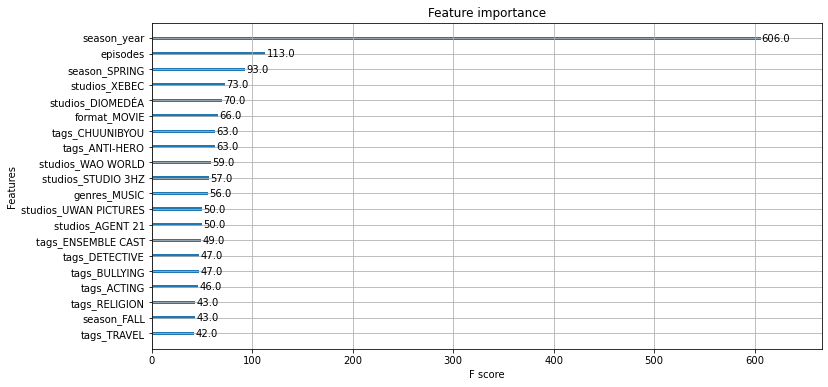

CPU times: total: 10.2 s
Wall time: 1.91 s


In [162]:
%%time

# Try retraining model with new hyperparameters

model = xgb.XGBRegressor(**hyper_best)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('Actual:', y_test.tolist()[0:10])
print('Predictions:', y_pred.tolist()[0:10])
print_model_error(y_test, y_pred)

fig, ax = plt.subplots(figsize=(12,6))
xgb.plot_importance(model, max_num_features=20, ax=ax)
plt.show()

## Conclusion

Yeah I'm dumb, I think I need to use classification models. Since my scores are discrete and only range from 1-10, I think I'm not getting a very good model using regression.
If my scores ranged from 1-100 I think I could probably get better predictions. 
So I'll treat score as ordinal categorical data and cross my fingers.

Other regression models to consider:

- `CatBoostRegressor`
- `LGBMRegressor`

Onto classification...I hope this works.